In [1]:
# Data Processing n' Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Compute
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Random
import os

-------------------------
# **Miscs**

In [2]:
data_dir = '/kaggle/input/wharton-dataset-basketball/data.csv'
dict_dir = '/kaggle/input/wharton-dataset-basketball/dict.csv'
infer_dir = '/kaggle/input/wharton-dataset-basketball/inference.csv'
region_dir = '/kaggle/input/wharton-dataset-basketball/region.csv'

In [3]:
df = pd.read_csv(data_dir)
df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,game_id,game_date,team,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,...,largest_lead,notD1_incomplete,OT_length_min_tot,rest_days,attendance,tz_dif_H_E,prev_game_dist,home_away,home_away_NS,travel_dist
0,game_2022_2011,2021-12-30,georgia_lady_bulldogs,61,27,11,5,6,3,14,...,1.0,False,NaN,9.0,3241.0,0.0,0.0,home,1,0.0
1,game_2022_2011,2021-12-30,lsu_tigers,61,28,11,4,15,8,15,...,14.0,False,NaN,3.0,3241.0,0.0,824.0,away,-1,824.0
2,game_2022_2012,2021-12-30,missouri_tigers,58,25,15,7,16,13,10,...,8.0,False,5.0,8.0,6139.0,0.0,371.0,home,1,0.0
3,game_2022_2012,2021-12-30,south_carolina_gamecocks,76,29,21,6,9,5,15,...,6.0,False,5.0,9.0,6139.0,0.0,1154.0,away,-1,1154.0
4,game_2022_2013,2021-12-30,tennessee_lady_volunteers,56,24,15,4,15,10,16,...,19.0,False,NaN,3.0,8124.0,0.0,0.0,home,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10433,game_2022_4795,2022-03-01,xavier_musketeers,56,21,12,2,12,9,15,...,0.0,False,NaN,2.0,156.0,0.0,0.0,home,1,0.0
10434,game_2022_4968,2022-03-04,harvard_crimson,69,34,39,15,10,2,20,...,40.0,False,NaN,13.0,373.0,0.0,378.0,away,-1,173.0
10435,game_2022_4968,2022-03-04,dartmouth_big_green,58,21,26,6,7,4,7,...,3.0,False,NaN,6.0,373.0,0.0,479.0,home,1,0.0
10436,game_2022_5067,2022-03-06,harvard_crimson,73,19,35,6,10,9,11,...,0.0,False,NaN,2.0,757.0,0.0,173.0,home,1,0.0


-----------------------------
# **Data Preprocessing**

In [4]:
"""
    Example Code for the Cell Below.

    Data Structure:
        mock_data -> list
        mock_data[idx] -> dict
"""

game_id = df['game_id'].unique()
print(f"This is the game_id of the first game: {game_id[0]}")
print("-"*59)

game_data = df[df['game_id'] == game_id[0]]
print("Stats of teams in game_id: ")
print(game_data)
print("-"*59)

mock_data = []

teamA = game_data.iloc[0]
teamB = game_data.iloc[1]

home_away = {
    -1: 'A',
    0: 'N',
    1: 'H'
}

mock_entry = {
    'teamA': teamA['team'],
    'teamB': teamB['team'],
    'teamA_score': teamA['team_score'],
    'teamB_score': teamB['team_score'],

    # We will perform Embedding for Home/Away/Neutral
    # Similar to NLP 
    # Input -> List of words -> Embedding
    'A_B_home': [home_away[teamA['home_away_NS']],
                 home_away[teamB['home_away_NS']]],

    # 0: Lost | 1: Won | 2: Draw
    'W/L/D (teamA)': 0 if teamA['team_score'] - teamB['team_score'] < 0
                    else 1 if teamA['team_score'] - teamB['team_score'] > 0
                    else 2
}
stats_to_diff = [
    'FGA_2', 'FGM_2', 'FGA_3', 'FGM_3', 'FTA',
    'FTM', 'AST', 'BLK', 'STL', 'TOV', 'TOV_team',
    'DREB', 'OREB', 'F_tech', 'F_personal', 'rest_days',
    'prev_game_dist', 'travel_dist'
]

for stat in stats_to_diff:
    
    if teamA[stat] == 'NA':
        print(f'Team A ({teamA["team"]}) {stat} has NA value. Converting to Team B ({teamB["team"]})...')
        teamA[stat] = teamB[stat]
    elif teamB[stat] == 'NA':
        print(f'Team B ({teamB["team"]}) {stat} has NA value. Converting to Team A (({teamA["team"]}))...')
        teamB[stat] = teamA[stat]
    else:
        print("No abnormalities")
        
    # Compute difference (A to B)
    mock_entry[f'{stat}_diff (A - B)'] = teamA[stat] - teamB[stat]
    
# Append to List
mock_data.append(mock_entry)

# Change to type pd
pd.DataFrame(mock_data)

display(mock_data)
print("-"*59)

This is the game_id of the first game: game_2022_2011
-----------------------------------------------------------
Stats of teams in game_id: 
          game_id   game_date                   team  FGA_2  FGM_2  FGA_3  \
0  game_2022_2011  2021-12-30  georgia_lady_bulldogs     61     27     11   
1  game_2022_2011  2021-12-30             lsu_tigers     61     28     11   

   FGM_3  FTA  FTM  AST  ...  largest_lead  notD1_incomplete  \
0      5    6    3   14  ...           1.0             False   
1      4   15    8   15  ...          14.0             False   

   OT_length_min_tot  rest_days  attendance  tz_dif_H_E  prev_game_dist  \
0                NaN        9.0      3241.0         0.0             0.0   
1                NaN        3.0      3241.0         0.0           824.0   

   home_away  home_away_NS  travel_dist  
0       home             1          0.0  
1       away            -1        824.0  

[2 rows x 30 columns]
----------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


[{'teamA': 'georgia_lady_bulldogs',
  'teamB': 'lsu_tigers',
  'teamA_score': 62,
  'teamB_score': 68,
  'A_B_home': ['H', 'A'],
  'W/L/D (teamA)': 0,
  'FGA_2_diff (A - B)': 0,
  'FGM_2_diff (A - B)': -1,
  'FGA_3_diff (A - B)': 0,
  'FGM_3_diff (A - B)': 1,
  'FTA_diff (A - B)': -9,
  'FTM_diff (A - B)': -5,
  'AST_diff (A - B)': -1,
  'BLK_diff (A - B)': 5,
  'STL_diff (A - B)': -8,
  'TOV_diff (A - B)': 4,
  'TOV_team_diff (A - B)': -2,
  'DREB_diff (A - B)': 0,
  'OREB_diff (A - B)': 0,
  'F_tech_diff (A - B)': 0,
  'F_personal_diff (A - B)': 11,
  'rest_days_diff (A - B)': 6.0,
  'prev_game_dist_diff (A - B)': -824.0,
  'travel_dist_diff (A - B)': -824.0}]

-----------------------------------------------------------


In [5]:
from sklearn.preprocessing import RobustScaler, StandardScaler

def normalize_wrt_category(data, stats_to_diff):
    """
    Normalize each category of features separately using Robust Scaling + Z-score normalization.
    
    Input:
        - data: Data to normalize w.r.t category -> pd
        - stats_to_diff: List of columns/features/categories to normalize w.r.t -> List

    Output:
        - data: Normalize Data using Robust Scaling -> Z-Score [2-step-Normalization]
    """
    
    epsilon = 1e-8  # Small value to prevent divide by zero

    for stat in stats_to_diff:   
        # Apply Robust Scaling first
        scaler_robust = RobustScaler()
        data[f'{stat}_diff (A - B)'] = scaler_robust.fit_transform(data[[f'{stat}_diff (A - B)']])

        # Apply Z-score normalization
        mean = data[f'{stat}_diff (A - B)'].mean()
        std = data[f'{stat}_diff (A - B)'].std()
        

        data[f'{stat}_diff (A - B)'] = (data[f'{stat}_diff (A - B)'] - mean) / (std + epsilon)  # Z-score with epsilon
    
    return data


def preprocess_data(data):
    
    """
    Preprocessed Data (1st Step)
        Input: 
        - data: Dataset File -> csv

        Output:
        - processed_df: Processed Dataset File -> pd
    """
    
    processed_data = []
    
    # Drop irrelevant columns
    data = data.drop(columns=[
        'notD1_incomplete', 'OT_length_min_tot', 'tz_dif_H_E', 'attendance'
    ])
    
    home_away = {-1: 'A', 0: 'N', 1: 'H'}

    stats_to_diff = [
        'FGA_2', 'FGM_2', 'FGA_3', 'FGM_3', 'FTA',
        'FTM', 'AST', 'BLK', 'STL', 'TOV', 'TOV_team',
        'DREB', 'OREB', 'F_tech', 'F_personal', 'rest_days',
        'prev_game_dist', 'travel_dist'
    ]

    # Process each game
    for game_id in data['game_id'].unique():
        game_data = data[data['game_id'] == game_id]

        # Ensure the game has exactly 2 teams
        if len(game_data) != 2:
            print(f"Skipping game {game_id} due to missing teams.")
            continue

        # Extract teams
        teamA = game_data.iloc[0]
        teamB = game_data.iloc[1]

        entry = {
            'teamA': teamA['team'],
            'teamB': teamB['team'],
            'teamA_score': teamA['team_score'],
            'teamB_score': teamB['team_score'],

            # Embedding for Home/Away/Neutral
            'A_B_home': [home_away[teamA['home_away_NS']], home_away[teamB['home_away_NS']]],

            # 0: Lost | 1: Won | 2: Draw
            'W/L/D (teamA)': 0 if teamA['team_score'] < teamB['team_score']
                            else 1 if teamA['team_score'] > teamB['team_score']
                            else 2
        }

        # Compute stat differences
        for stat in stats_to_diff:
            # Handle NA values
            if pd.isna(teamB[stat]) and pd.isna(teamA[stat]):
                teamA[stat], teamB[stat] = 0, 0
                
            elif pd.isna(teamA[stat]):
                print(f"Team A ({teamA['team']}) {stat} has NA. Using Team B's value.")
                teamA[stat] = teamB[stat]
                
            elif pd.isna(teamB[stat]):
                print(f"Team B ({teamB['team']}) {stat} has NA. Using Team A's value.")
                teamB[stat] = teamA[stat]
                
            # Compute difference
            entry[f'{stat}_diff (A - B)'] = teamA[stat] - teamB[stat]
        
        processed_data.append(entry)

    # Convert to DataFrame
    processed_df = pd.DataFrame(processed_data)

    # Normalize the features
    processed_df = normalize_wrt_category(processed_df, stats_to_diff)

    return processed_df

In [6]:
data = preprocess_data(df)

Team B (iowa_hawkeyes) travel_dist has NA. Using Team A's value.
Team A (iowa_hawkeyes) travel_dist has NA. Using Team B's value.
Team B (iowa_hawkeyes) travel_dist has NA. Using Team A's value.
Team B (iowa_hawkeyes) travel_dist has NA. Using Team A's value.
Team B (iowa_hawkeyes) travel_dist has NA. Using Team A's value.
Team B (iowa_hawkeyes) travel_dist has NA. Using Team A's value.
Team B (iowa_hawkeyes) travel_dist has NA. Using Team A's value.


<ipython-input-5-ce321e24f8bf>:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teamB[stat] = teamA[stat]
<ipython-input-5-ce321e24f8bf>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teamA[stat] = teamB[stat]
<ipython-input-5-ce321e24f8bf>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teamA[stat], teamB[stat] = 0, 0


Team B (southern_jaguars) rest_days has NA. Using Team A's value.
Team B (southern_jaguars) prev_game_dist has NA. Using Team A's value.
Team A (kent_state_golden_flashes) prev_game_dist has NA. Using Team B's value.
Team A (little_rock_trojans) prev_game_dist has NA. Using Team B's value.
Team A (little_rock_trojans) prev_game_dist has NA. Using Team B's value.
Team B (santa_clara_broncos) prev_game_dist has NA. Using Team A's value.
Team A (north_carolina_tar_heels) travel_dist has NA. Using Team B's value.
Team A (western_illinois_leathernecks) rest_days has NA. Using Team B's value.
Team A (western_illinois_leathernecks) prev_game_dist has NA. Using Team B's value.
Team A (kennesaw_state_owls) prev_game_dist has NA. Using Team B's value.
Team B (louisville_cardinals) rest_days has NA. Using Team A's value.
Team B (louisville_cardinals) prev_game_dist has NA. Using Team A's value.
Team A (bethune_cookman_wildcats) prev_game_dist has NA. Using Team B's value.
Team B (lafayette_leopar

In [7]:
data

,teamA,teamB,teamA_score,teamB_score,A_B_home,W/L/D (teamA),FGA_2_diff (A - B),FGM_2_diff (A - B),FGA_3_diff (A - B),FGM_3_diff (A - B),...,STL_diff (A - B),TOV_diff (A - B),TOV_team_diff (A - B),DREB_diff (A - B),OREB_diff (A - B),F_tech_diff (A - B),F_personal_diff (A - B),rest_days_diff (A - B),prev_game_dist_diff (A - B),travel_dist_diff (A - B)
0,georgia_lady_bulldogs,lsu_tigers,62,68,"[H, A]",0,0.003833,-0.112495,0.005966,0.233108,...,-1.573860,0.588446,-1.561942,0.017397,0.025630,-0.011069,2.019137,1.729692,-1.093695,-0.984109
1,missouri_tigers,south_carolina_gamecocks,70,69,"[H, A]",1,-1.671128,-0.469692,-0.636046,0.233108,...,0.177604,0.007898,0.781420,0.511512,-2.087983,-0.011069,-0.789266,-0.272489,-1.039093,-1.375353
2,tennessee_lady_volunteers,alabama_crimson_tide,62,44,"[H, A]",1,-1.391968,0.840030,-1.492063,-0.236981,...,-0.017003,0.588446,0.781420,1.376214,-0.880204,-0.011069,-0.602039,-3.990825,-0.580967,-0.527658
3,auburn_tigers,alabama_crimson_tide,53,56,"[A, H]",0,0.189940,0.006570,-0.315040,-0.236981,...,-0.211611,0.443309,-0.780821,-0.229661,-0.125343,-2.074231,-0.227585,2.873795,-0.318610,0.226375
4,tennessee_lady_volunteers,arkansas_razorbacks,70,63,"[A, H]",1,-2.136395,0.006570,-3.525102,-1.647246,...,-1.379253,1.604404,-0.780821,1.993859,-0.276315,-0.011069,-1.538173,-2.560696,1.228897,1.083554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5214,binghamton_bearcats,umbc_retrievers,58,48,"[H, A]",1,-0.554487,0.720965,0.219970,-0.236981,...,-0.600825,0.443309,-0.780821,1.129157,-0.729232,-0.011069,-0.414812,0.299563,-0.860637,-0.385388
5215,south_dakota_coyotes,western_illinois_leathernecks,75,48,"[A, H]",1,1.678795,1.316293,-0.208038,0.468152,...,1.150639,-1.588609,0.000299,0.264455,1.384380,2.052093,-2.099854,0.013537,-0.832670,0.678084
5216,seton_hall_pirates,xavier_musketeers,74,53,"[A, H]",1,0.841314,0.959096,1.396993,1.408329,...,1.150639,-0.282376,0.000299,0.511512,0.780491,-0.011069,-0.040358,0.585589,0.540376,1.052729
5217,harvard_crimson,dartmouth_big_green,85,52,"[A, H]",1,1.027421,1.554425,1.396993,2.113461,...,1.734461,-2.169157,-1.561942,-0.106132,0.025630,-0.011069,-0.040358,2.015718,-0.130832,0.197921


# **Feature Selection**

In [8]:
y = data['W/L/D (teamA)']
X = data[
            [
        'FGA_2_diff (A - B)', 'FGM_2_diff (A - B)',
       'FGA_3_diff (A - B)', 'FGM_3_diff (A - B)', 'FTA_diff (A - B)',
       'FTM_diff (A - B)', 'AST_diff (A - B)', 'BLK_diff (A - B)',
       'STL_diff (A - B)', 'TOV_diff (A - B)', 'TOV_team_diff (A - B)',
       'DREB_diff (A - B)', 'OREB_diff (A - B)', 'F_tech_diff (A - B)',
       'F_personal_diff (A - B)', 'rest_days_diff (A - B)',
       'prev_game_dist_diff (A - B)', 'travel_dist_diff (A - B)'
            ]
]
X_y = data[
            [
        'FGA_2_diff (A - B)', 'FGM_2_diff (A - B)',
       'FGA_3_diff (A - B)', 'FGM_3_diff (A - B)', 'FTA_diff (A - B)',
       'FTM_diff (A - B)', 'AST_diff (A - B)', 'BLK_diff (A - B)',
       'STL_diff (A - B)', 'TOV_diff (A - B)', 'TOV_team_diff (A - B)',
       'DREB_diff (A - B)', 'OREB_diff (A - B)', 'F_tech_diff (A - B)',
       'F_personal_diff (A - B)', 'rest_days_diff (A - B)',
       'prev_game_dist_diff (A - B)', 'travel_dist_diff (A - B)', 'W/L/D (teamA)'
            ]
]

In [9]:
y

0       0
1       1
2       1
3       0
4       1
       ..
5214    1
5215    1
5216    1
5217    1
5218    0
Name: W/L/D (teamA), Length: 5219, dtype: int64

In [10]:
X

,FGA_2_diff (A - B),FGM_2_diff (A - B),FGA_3_diff (A - B),FGM_3_diff (A - B),FTA_diff (A - B),FTM_diff (A - B),AST_diff (A - B),BLK_diff (A - B),STL_diff (A - B),TOV_diff (A - B),TOV_team_diff (A - B),DREB_diff (A - B),OREB_diff (A - B),F_tech_diff (A - B),F_personal_diff (A - B),rest_days_diff (A - B),prev_game_dist_diff (A - B),travel_dist_diff (A - B)
0,0.003833,-0.112495,0.005966,0.233108,-1.005771,-0.707163,-0.125721,1.548651,-1.573860,0.588446,-1.561942,0.017397,0.025630,-0.011069,2.019137,1.729692,-1.093695,-0.984109
1,-1.671128,-0.469692,-0.636046,0.233108,0.810101,1.152845,-0.664973,-2.195371,0.177604,0.007898,0.781420,0.511512,-2.087983,-0.011069,-0.789266,-0.272489,-1.039093,-1.375353
2,-1.391968,0.840030,-1.492063,-0.236981,0.810101,0.723612,1.087598,0.924647,-0.017003,0.588446,0.781420,1.376214,-0.880204,-0.011069,-0.602039,-3.990825,-0.580967,-0.527658
3,0.189940,0.006570,-0.315040,-0.236981,-1.005771,-0.277931,-0.260534,-0.323360,-0.211611,0.443309,-0.780821,-0.229661,-0.125343,-2.074231,-0.227585,2.873795,-0.318610,0.226375
4,-2.136395,0.006570,-3.525102,-1.647246,2.852957,2.011311,0.952785,-0.635362,-1.379253,1.604404,-0.780821,1.993859,-0.276315,-0.011069,-1.538173,-2.560696,1.228897,1.083554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5214,-0.554487,0.720965,0.219970,-0.236981,-0.438311,-0.134853,1.087598,1.860652,-0.600825,0.443309,-0.780821,1.129157,-0.729232,-0.011069,-0.414812,0.299563,-0.860637,-0.385388
5215,1.678795,1.316293,-0.208038,0.468152,0.356133,0.437457,0.548345,-0.947364,1.150639,-1.588609,0.000299,0.264455,1.384380,2.052093,-2.099854,0.013537,-0.832670,0.678084
5216,0.841314,0.959096,1.396993,1.408329,0.015657,-0.134853,1.357224,0.300643,1.150639,-0.282376,0.000299,0.511512,0.780491,-0.011069,-0.040358,0.585589,0.540376,1.052729
5217,1.027421,1.554425,1.396993,2.113461,0.356133,-0.277931,1.761663,0.300643,1.734461,-2.169157,-1.561942,-0.106132,0.025630,-0.011069,-0.040358,2.015718,-0.130832,0.197921


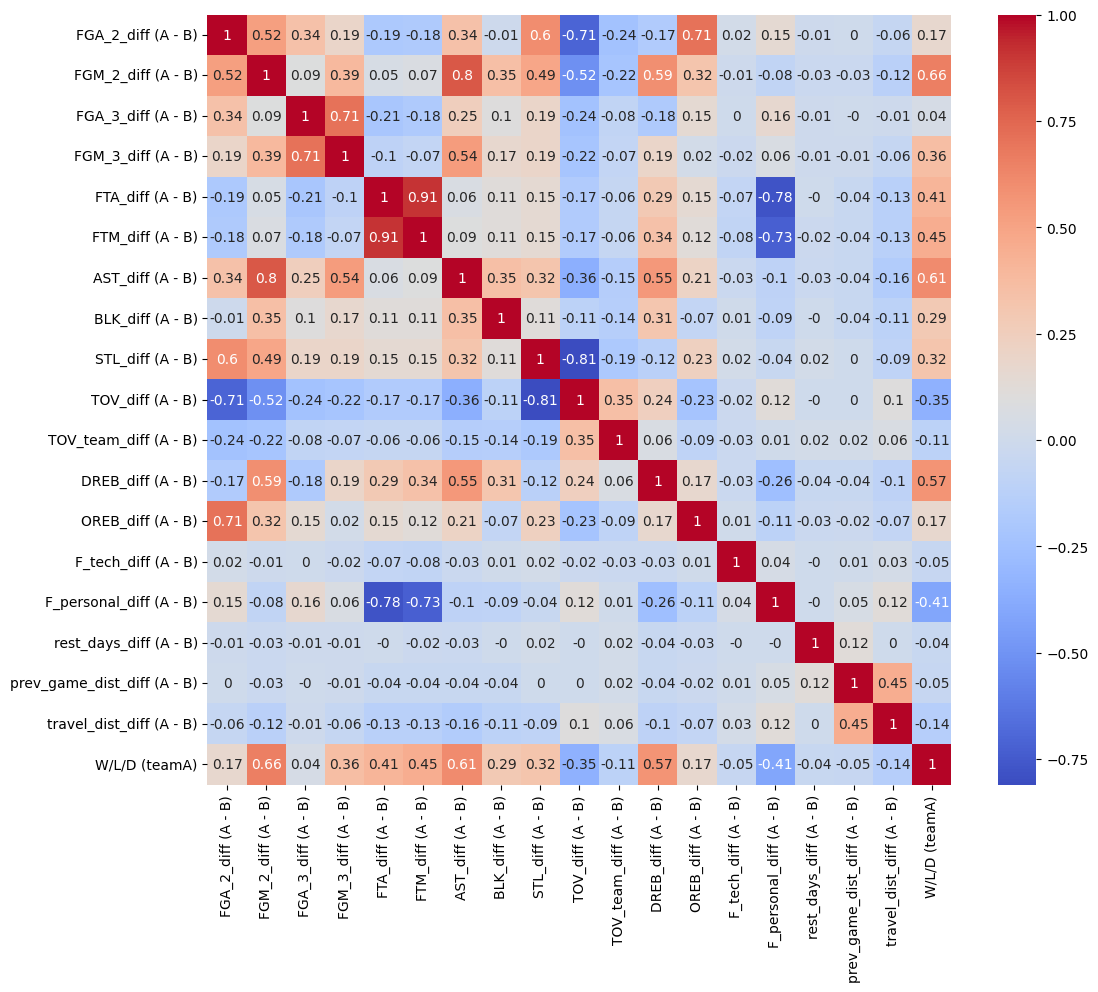

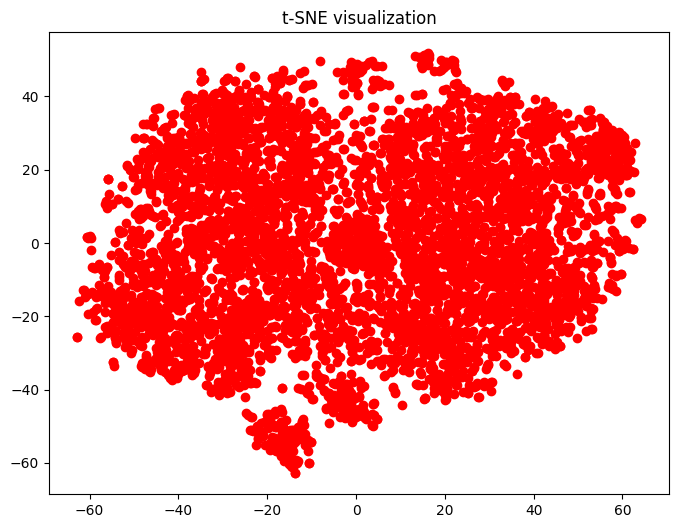

Results of Variance Threshold:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
--------------------------------------------------
Results of Correlation Matrix:
set()
--------------------------------------------------
Results of Univariate Selection:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
--------------------------------------------------
Results of Chi-Square Test:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
--------------------------------------------------
Results of Mutual Information:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
--------------------------------------------------
Results of RFE:
[False  True False False  True  True  True False False False False  True
 False False False False False False]
--------------

In [11]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.manifold import TSNE

# 1. **Variance Threshold**
def variance_threshold(X):
    selector = VarianceThreshold(threshold=0.01)  # Keep features with variance > 0.01
    X_var = selector.fit_transform(X)
    return X_var, selector.get_support()

# 2. **Correlation Matrix - Remove Highly Correlated Features**
def correlation_matrix(X):
    corr = X.corr().round(2)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.show()
    # Remove features with high correlation (> 0.95)
    correlated_features = set()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > 0.95:
                colname = corr.columns[i]
                correlated_features.add(colname)
    X_corr = X.drop(columns=correlated_features)
    return X_corr, correlated_features

# 3. **Univariate Selection (ANOVA F-test)**
def univariate_selection(X, y):
    selector = SelectKBest(f_classif, k='all')
    X_new = selector.fit_transform(X, y)
    return X_new, selector.get_support()

# 4. **Chi-Square Test (for categorical data)**
def chi_square(X, y):
    # Make sure features are non-negative
    X_chi = X.copy()
    X_chi = X_chi.select_dtypes(include=['int64', 'float64'])  # Ensure it's numeric
    X_chi = X_chi - X_chi.min()  # Normalize to non-negative values
    selector = SelectKBest(chi2, k='all')
    X_new = selector.fit_transform(X_chi, y)
    return X_new, selector.get_support()

# 5. **Mutual Information (for classification problems)**
def mutual_information(X, y):
    selector = SelectKBest(mutual_info_classif, k='all')
    X_new = selector.fit_transform(X, y)
    return X_new, selector.get_support()

# 6. **Recursive Feature Elimination (RFE)**
from sklearn.feature_selection import RFE
def rfe(X, y):
    estimator = RandomForestClassifier(n_estimators=100)
    selector = RFE(estimator, n_features_to_select=5, step=1)
    X_rfe = selector.fit_transform(X, y)
    return X_rfe, selector.support_

# 7. **Lasso (L1 Regularization)**
def lasso(X, y):
    lasso = LassoCV()
    lasso.fit(X, y)
    importance = np.abs(lasso.coef_)
    return importance

# 8. **Random Forest Feature Importance**
def random_forest(X, y):
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X, y)
    return rf.feature_importances_

# 9. **Permutation Feature Importance**
def permutation_importance_func(X, y):
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X, y)
    results = permutation_importance(rf, X, y, n_repeats=10, random_state=42)
    return results.importances_mean

# 10. **Principal Component Analysis (PCA)**
def pca(X):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    return X_pca

# 11. **t-SNE for Visualizing High-Dimensional Data**
def tsne(X):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='r', marker='o')
    plt.title('t-SNE visualization')
    plt.show()
    return X_tsne

# Normalization Function for Data
def normalize_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

# Combining all Feature Selection Techniques
def feature_selection(X, y, X_y):
    results = {}

    # Variance Threshold
    X_var, var_support = variance_threshold(X)
    results['Variance Threshold'] = var_support

    # Correlation Matrix
    X_corr, corr_features = correlation_matrix(X_y)
    results['Correlation Matrix'] = corr_features

    # Univariate Selection (ANOVA)
    X_uni, uni_support = univariate_selection(X, y)
    results['Univariate Selection'] = uni_support

    # Chi-Square Test
    X_chi, chi_support = chi_square(X, y)
    results['Chi-Square Test'] = chi_support

    # Mutual Information
    X_mi, mi_support = mutual_information(X, y)
    results['Mutual Information'] = mi_support

    # RFE (Recursive Feature Elimination)
    X_rfe, rfe_support = rfe(X, y)
    results['RFE'] = rfe_support

    # Lasso (L1 Regularization)
    lasso_importance = lasso(X, y)
    results['Lasso'] = lasso_importance

    # Random Forest Feature Importance
    rf_importance = random_forest(X, y)
    results['Random Forest'] = rf_importance

    # Permutation Feature Importance
    perm_importance = permutation_importance_func(X, y)
    results['Permutation Importance'] = perm_importance

    # PCA (Dimensionality Reduction)
    X_pca = pca(X)
    results['PCA'] = X_pca

    # t-SNE (for Visualization)
    X_tsne = tsne(X)
    results['t-SNE'] = X_tsne

    return results


# Applying all feature selection techniques
results = feature_selection(X, y, X_y)

# Example of analyzing the results (can be customized based on your needs)
for key, value in results.items():
    print(f"Results of {key}:")
    print(value)
    print("-" * 50)